In [3]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from datetime import datetime
from tqdm import tqdm

from Models.Model import *
from data_generation.generate_data import Simulation
from data_generation.plotting import PlotBuilder
from data_generation.plotting import plot_state_and_myu

In [4]:
simulation = Simulation(
    d=(0.0005, 0.15, 0.15),
    N=(750, 64, 64),
    myu_size=(50, 4, 4),
    myu_mstd=(1.0, 10.5)
)

In [5]:
state, myu = simulation.compute()

Computing States: 100%|██████████| 749/749 [00:00<00:00, 2220.55it/s]


In [6]:
from Models.NewModel import AdaptedPINN, prepare_data

In [9]:
model = AdaptedPINN(
    Nt=750,
    Nx=64,
    Ny=64,
    dt=0.0005,
    dx=0.15,
    dy=0.15,
    delta=0.01,
    weight_pde=0.1,
    device='cuda'
)

In [10]:
data_tensors = prepare_data(state, myu)
model.train_model(
    data_tensors['x_data'], data_tensors['y_data'], data_tensors['t_data'],
    data_tensors['Ar_data'], data_tensors['Ai_data'],
    data_tensors['x_eqs'], data_tensors['y_eqs'], data_tensors['t_eqs'],
    n_epochs=100,
    lr=1e-3,
    batch_size=512
)

Epoch 0: Train Loss = 1.5047e+03, Val Loss = 1.1434e+02


In [11]:
def predict_full_field(model, Nt, Nx, Ny, dt, dx, dy, device='cuda'):
    """Predict A for the full domain."""
    # Create meshgrid for the full domain
    t_vals = np.arange(Nt) * dt
    x_vals = np.arange(Nx) * dx
    y_vals = np.arange(Ny) * dy

    # Initialize arrays for predictions
    A_pred = np.zeros((Nt, Nx, Ny), dtype=np.complex64)

    # Predict for each time frame
    for i, t_val in enumerate(tqdm(t_vals, desc="Predicting A")):
        X, Y = np.meshgrid(x_vals, y_vals, indexing='ij')
        XX = X.ravel()
        YY = Y.ravel()
        TT = np.full_like(XX, t_val)

        # Convert to tensors
        x_test = torch.tensor(XX, dtype=torch.float32, device=device).view(-1, 1)
        y_test = torch.tensor(YY, dtype=torch.float32, device=device).view(-1, 1)
        t_test = torch.tensor(TT, dtype=torch.float32, device=device).view(-1, 1)

        # Predict
        with torch.no_grad():
            A_r, A_i = model.net_A(x_test, y_test, t_test)

        # Reshape and store
        A_r_2d = A_r.cpu().numpy().reshape(Nx, Ny)
        A_i_2d = A_i.cpu().numpy().reshape(Nx, Ny)
        A_pred[i] = A_r_2d + 1j * A_i_2d

    return A_pred

def extract_myu(model):
    """Extract the learned MYU field."""
    # Get the full MYU (after time expansion)
    myu_full = model.expand_myu_full()  # Shape: (Nt, Nx, Ny)

    # Get the compact MYU (before expansion)
    with torch.no_grad():
        myu_compact = model.mu_small.cpu().numpy()
        myu_compact_binary = (myu_compact > 0.0).astype(float) * 255.0

    return myu_full, myu_compact_binary

# After training, use:
# Load the best model
model.load_state_dict(torch.load("./results/AdaptedPINN_best.pt"))
model.eval()

# Get predictions
A_predicted = predict_full_field(model, Nt=750, Nx=64, Ny=64, dt=0.05, dx=0.3, dy=0.3)
myu_full, myu_compact = extract_myu(model)

# Save results
np.save("A_predicted.npy", A_predicted)
np.save("myu_predicted_full.npy", myu_full)
np.save("myu_predicted_compact.npy", myu_compact)

C:\Users\meloy\AppData\Local\Temp\ipykernel_23624\2918549923.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./results/AdaptedPINN_bes

In [21]:
myu_full[100]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [24]:
def check_gradients(model):
    print("mu_small gradient:", model.mu_small.grad)
    print("mu_small values (before binarization):", model.mu_small.data.min(), model.mu_small.data.max())
    print("mu_small requires_grad:", model.mu_small.requires_grad)

check_gradients(model)

mu_small gradient: None
mu_small values (before binarization): tensor(0., device='cuda:0') tensor(0., device='cuda:0')
mu_small requires_grad: True


In [22]:
def identify_unique_values(tensor):
    """
    Identify all unique values in a given tensor.

    Args:
        tensor: A numpy array or PyTorch tensor

    Returns:
        A sorted array of unique values and their counts
    """
    # Convert to numpy if it's a PyTorch tensor
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.detach().cpu().numpy()

    # Find unique values and their counts
    unique_values, counts = np.unique(tensor, return_counts=True)

    # Create a structured result
    result = [(val, count) for val, count in zip(unique_values, counts)]

    print(f"Found {len(unique_values)} unique values in tensor of shape {tensor.shape}")
    print(f"Unique values: {unique_values}")
    print(f"Counts: {counts}")

    return unique_values, counts

# Example usage for myu_full
unique_vals, counts = identify_unique_values(myu_full)

Found 1 unique values in tensor of shape (750, 64, 64)
Unique values: [0.]
Counts: [3072000]


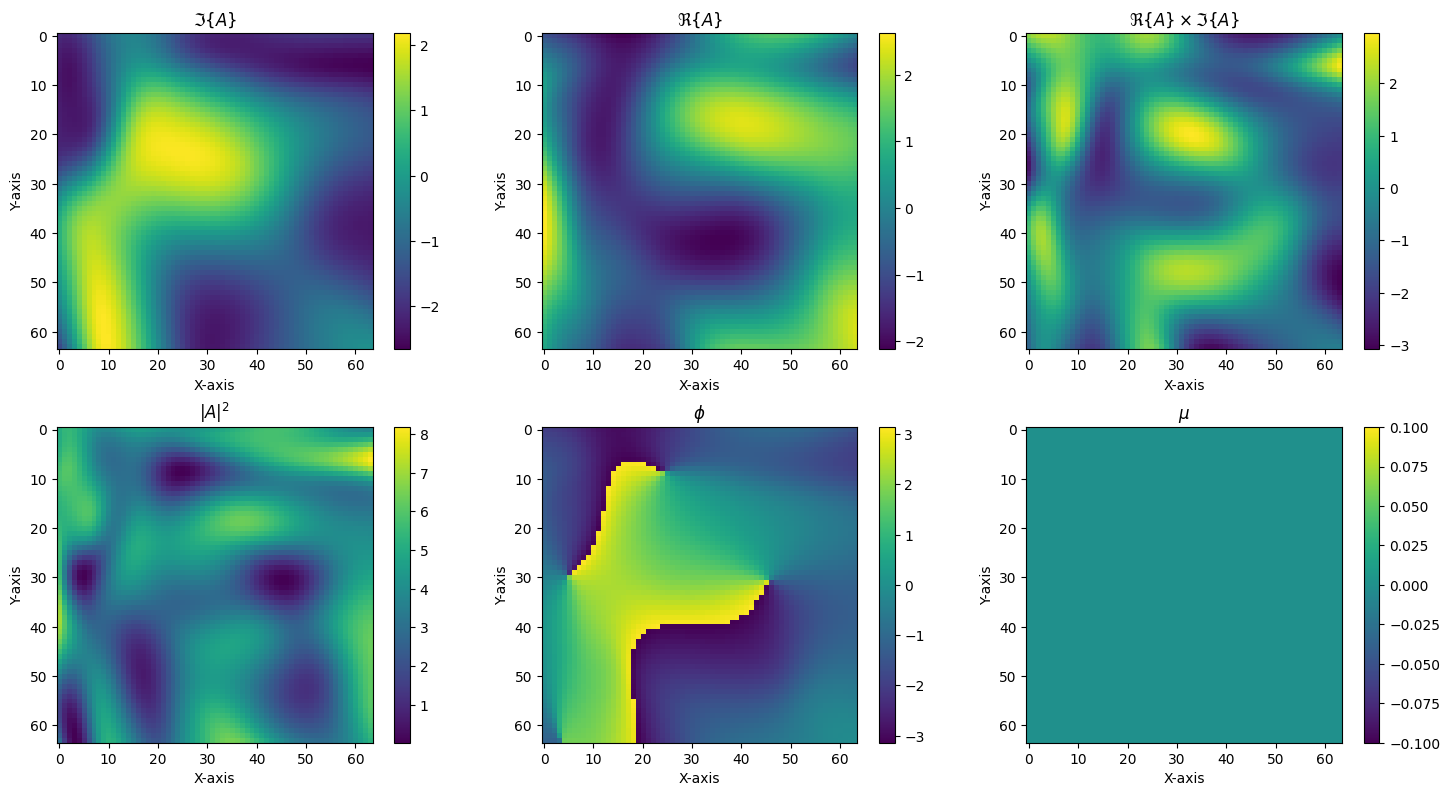

In [28]:
from data_generation.plotting import plot_state_and_myu

plot_state_and_myu(A_predicted, myu_full, len(state) -1)

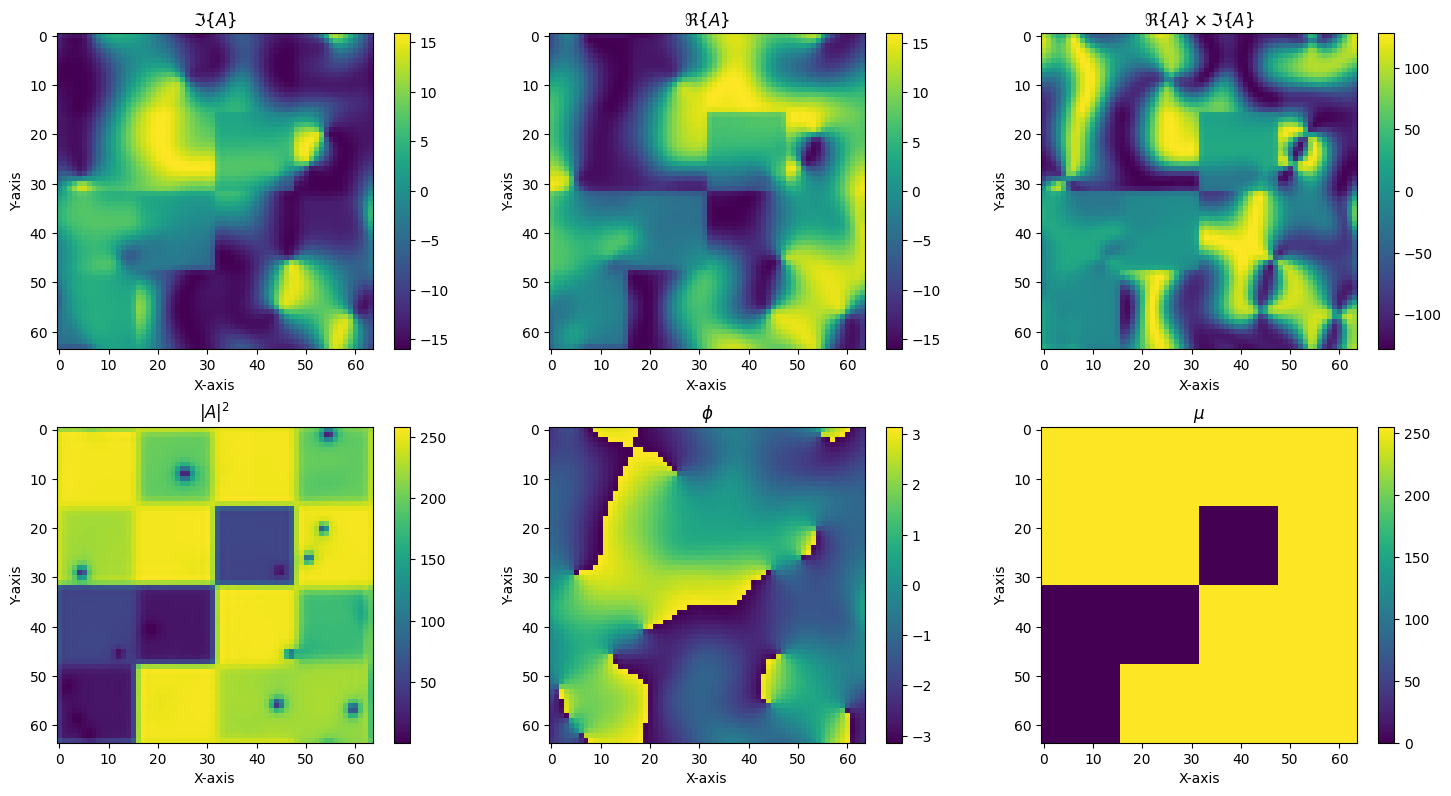

In [30]:
plot_state_and_myu(state, myu, len(state) -1)

In [ ]:
import matplotlib.pyplot as plt

# Compare at specific time frame
t_frame = 100
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original vs Predicted A
axes[0,0].imshow(np.abs(state[t_frame]), cmap='viridis')
axes[0,0].set_title('Original |A|')

axes[0,1].imshow(np.abs(A_predicted[t_frame]), cmap='viridis')
axes[0,1].set_title('Predicted |A|')

axes[0,2].imshow(np.abs(state[t_frame] - A_predicted[t_frame]), cmap='hot')
axes[0,2].set_title('Absolute Error')

# Original vs Predicted MYU
axes[1,0].imshow(myu[t_frame], cmap='gray')
axes[1,0].set_title('Original MYU')

axes[1,1].imshow(myu_full[t_frame], cmap='gray')
axes[1,1].set_title('Predicted MYU')

axes[1,2].imshow(np.abs(myu[t_frame] - myu_full[t_frame]), cmap='hot')
axes[1,2].set_title('MYU Difference')

plt.tight_layout()
plt.savefig("comparison.png")
plt.show()

# Create animation
def create_comparison_animation(state, A_pred, myu, myu_pred, output_path="comparison.mp4"):
    """Create animation comparing original and predicted fields."""
    import matplotlib.animation as animation

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    def update(frame):
        for ax in axes.flat:
            ax.clear()

        # Plot A
        im1 = axes[0,0].imshow(np.abs(state[frame]), cmap='viridis')
        axes[0,0].set_title(f'Original |A| (t={frame})')

        im2 = axes[0,1].imshow(np.abs(A_pred[frame]), cmap='viridis')
        axes[0,1].set_title(f'Predicted |A| (t={frame})')

        # Plot MYU
        im3 = axes[1,0].imshow(myu[frame], cmap='gray', vmin=0, vmax=255)
        axes[1,0].set_title(f'Original MYU (t={frame})')

        im4 = axes[1,1].imshow(myu_pred[frame], cmap='gray', vmin=0, vmax=255)
        axes[1,1].set_title(f'Predicted MYU (t={frame})')

        return [im1, im2, im3, im4]

    anim = animation.FuncAnimation(fig, update, frames=state.shape[0], interval=50)
    anim.save(output_path, writer='ffmpeg', fps=20)
    plt.close()

create_comparison_animation(state, A_predicted, myu, myu_full)